<a href="https://colab.research.google.com/github/TemsyChen/DS-Unit-2-Kaggle-Challenge/blob/master/TemsyChen_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

Import libraries

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


Wrangle Data

In [ ]:
#Transform the target column into binary classfication

train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [ ]:
#Engineer the target into a binary classification

#train['functional'] = train['status_group'].apply(lambda x: 1 if x=='functional' else 0)

In [ ]:
#Define a function to wrangle the data sets

def wrangle(X):
  #make a copy of the dataframe
  X = X.copy()

  #set 'id' to index
  X = X.set_index('id')

  #replace 0 values with NaN, including near zeroes
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  zero_col = ['latitude', 'longitude','construction_year','gps_height','population']
  for col in zero_col:
    X[col] = X[col].replace(0, np.nan)
    
  #drop duplicate or not useful features
  X = X.drop(columns=['quantity_group','payment_type','recorded_by'])

  #Create new binary target
  if 'status_group' in X.columns:
    X['functional'] = (X['status_group'] == 'functional').astype(int)
    X.drop(columns='status_group', inplace=True)

  return X

In [ ]:
train = wrangle(train)
test = wrangle(test)

In [ ]:
train.head(10)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,functional
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1
8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,NaN,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1
67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0.0,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,NaN,True,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1
9944,20.0,2011-03-13,Mkinga Distric Coun,NaN,DWE,39.172796,-4.765587,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1.0,True,VWC,Zingibali,True,2009.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,salty,salty,enough,other,other,unknown,communal standpipe multiple,communal standpipe,1
19816,0.0,2012-10-01,Dwsp,NaN,DWSP,33.362410,-3.766365,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,NaN,True,VWC,NaN,True,NaN,swn 80,swn 80,handpump,vwc,user-group,never pay,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump,0
54551,0.0,2012-10-09,Rwssp,NaN,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,NaN,True,NaN,NaN,True,NaN,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,milky,milky,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0
53934,0.0,2012-11-03,Wateraid,NaN,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,NaN,True,VWC,NaN,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,salty,salty,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,0


In [ ]:
#Check that functional = 1, and all else = 0

train['functional'].value_counts()

1    32259
0    27141
Name: functional, dtype: int64

Split Data

In [ ]:
#split data into train and validation sets
target = 'functional'
y = train[target]
X = train.drop(columns=target)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=37)

#check it is correct
assert len(X_train)+len(X_val)==len(X)

In [ ]:
#check shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((47520, 36), (47520,), (11880, 36), (11880,))

Baseline

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425294612794613


Build Model

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=37, n_jobs=-1, max_depth=20, n_estimators=324)
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date_recorded', 'funder', 'installer',
                                      'wpt_name', 'basin', 'subvillage',
                                      'region', 'lga', 'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_sample

Check Metrics

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9723905723905724
Validation Accuracy: 0.8311447811447812


Confusion Matrix

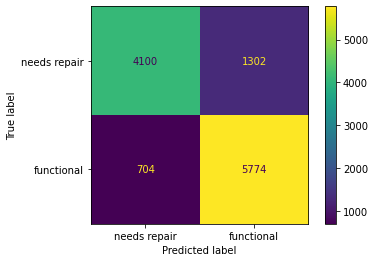

In [ ]:
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format='.0f',
                      display_labels=['needs repair','functional']);

**Recall**


*   Of the pumps that actually need repair, how many were correctly predicted as needing repair?


*   TP/TP+FN, in this case TN/TN+FP




In [ ]:
print('Recall:', 4100/(4100+1302))

Recall: 0.7589781562384302


**Precision**


*   Of the pumps that were predicted as needing repair, how many actually needed repair?
*   TP/TP+FP, in this case TN/TN+FN



In [ ]:
print('Precision:', 4100/(4100+704))

Precision: 0.8534554537885096


Classification Report

In [ ]:
print(classification_report(y_val, model.predict(X_val), target_names=['needs repair','functional']))

              precision    recall  f1-score   support

needs repair       0.85      0.76      0.80      5402
  functional       0.82      0.89      0.85      6478

    accuracy                           0.83     11880
   macro avg       0.83      0.83      0.83     11880
weighted avg       0.83      0.83      0.83     11880



In [ ]:
model.predict_proba(X_val)[:10, -1]

array([0.95317814, 0.01920583, 0.08859316, 0.95441204, 0.78495903,
       0.79653674, 0.50567838, 0.63474626, 0.56816371, 0.0817041 ])

Case Study:

Ex. Tanzanian govt spend $100 to inspect a water pump, and there is only enough to inspect 2000 pumps.

In [ ]:
#scenario 1, choose random pumps
n_inspections = 2000

#number of actual pumps that need repair
repair_prob = y_val.value_counts(n_inspections).min()

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', round(n_inspections*repair_prob))
print('Funds wasted:', n_inspections*(1-repair_prob)*100)

Inspections conducted: 2000
Pumps repaired: 909
Funds wasted: 109057.23905723906


In [ ]:
#scenario 2, using the model

data = {'y_val':y_val,
        'y_pred':model.predict(X_val)}

results = pd.DataFrame(data)

#mask finds the pumps that need repair
mask = results['y_pred']==0
sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', (2000-sample['y_val'].sum())) #taking the actual needs repair from 2000 randomly chosen predicted needs repair
                                                      #I had to do 2000- because my binary classification is the opposite of how the class lecture classfied 1's and 0's
print('Funds wasted:', (n_inspections-(2000-sample['y_val'].sum()))*100)

Inspections conducted: 2000
Pumps repaired: 1708
Funds wasted: 29200


In [79]:
#scenario 3, emphasize precision in our model, only select pumps that the model is certain (>0.9) need repair.

data = {'y_val': y_val,
        'y_pred_proba': model.predict_proba(X_val)[:,-1]}

results = pd.DataFrame(data)

threshold = 0.87 #.9 could not produce enough results to fulfill the number of inspections

mask = results['y_pred_proba']>threshold

sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:',(n_inspections-sample.y_val.sum())*100)

Inspections conducted: 2000
Pumps repaired: 1930
Funds wasted: 7000


Get ROC AUC

In [82]:
#use scikit-learn to calculate TPR and FPR at various thresholds

y_pred_proba = model.predict_proba(X_val)[:,-1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [84]:
#See the results in a table

pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
}).head(10)

,False Positive Rate,True Positive Rate,Threshold
0,0.0,0.000000,1.999210
1,0.0,0.000154,0.999210
2,0.0,0.002316,0.997317
3,0.0,0.002933,0.997246
4,0.0,0.004631,0.996479
5,0.0,0.004940,0.996467
6,0.0,0.006638,0.995908
7,0.0,0.006947,0.995883
8,0.0,0.008645,0.995545
9,0.0,0.008953,0.995542


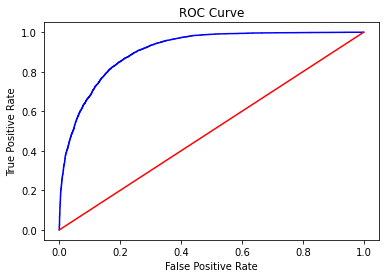

In [87]:
#See the results on a plot
#This is the ROC curve (Receiver Operating Characteristic)

plt.plot(fpr, tpr, color='blue')
plt.plot((0,1),(0,1), color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [88]:
#use scikit-learn to calculate the area under the curve

roc_auc_score(y_val, y_pred_proba)

0.909081976430579